In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random

In [2]:
rnd = np.random
rnd.seed(3)

In [3]:
# No of depots
I = 3

# No of customers
J = 25

# No of vehicles
K = 4

# price of route balance compared to logistical cost
W = 0.4

In [4]:
xc = rnd.rand(I+J)*200
yc = rnd.rand(I+J)*100

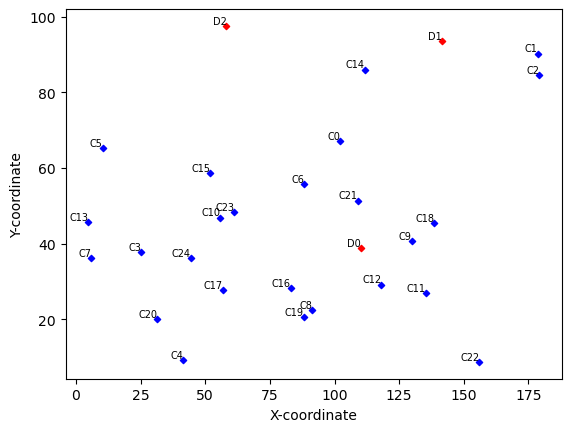

In [5]:
def plot_init(xc, yc):
    # Mark the depots with labels and red color
    for i in range(len(xc)):
        label = f'D{i}' if i < I else f'C{i - I}'
        color = 'red' if i < I else 'blue'  # Mark depots with red and customers with blue
        plt.scatter(xc[i], yc[i], marker='D', s=10, color=color)
        plt.text(xc[i], yc[i], label, fontsize=7, color='black', ha='right', va='bottom')

#     plt.title('MDVRP - Vehicle Paths')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.savefig("initial2.png")
#     plt.grid(True)
    plt.show()

# Plot the paths with labels and mark depots with red color
plot_init(xc, yc)

In [6]:
# Set of all depots
IS = [i for i in range(0,I)]

# Set of all customers
JS = [j for j in range(I, I+J)]

# Set of all vehicles
KS = [k for k in range(0,K)]

# U is IUJ
U = IS + JS

# All pairs of (i,j)
A = [(i,j) for i in U for j in U]

# All pairs of (i,j,k)
B = [(i,j,k) for i,j in A for k in KS]

# Distance matrix
c = {(i,j): np.hypot(xc[i]-xc[j],yc[i]-yc[j]) for i,j in A}

# Time matrix
t = {(i,j): np.hypot(xc[i]-xc[j],yc[i]-yc[j])/10 for i,j in A}

# Demand of customer, it is negative in case of delivery, excluding 0
PD = {j: rnd.choice(list(range(1, 11))) for j in JS}
DD = {j: rnd.choice(list(range(1, 11))) for j in JS}
d = {j: DD[j] - PD[j] for j in JS}

#Capacity of vehicles
Q = [100, 50, 100, 150]

# Start time
a = {j: rnd.randint(1,10) for j in JS}

# End time
b = {j: a[j] + rnd.randint(1,50) for j in JS}

# For satisfying time constraint
M = 1000000

In [7]:
from gurobipy import Model, GRB, quicksum
model = Model('MDVRPSPD')
x = model.addVars(B, vtype=GRB.BINARY)
l = model.addVars(B, vtype=GRB.CONTINUOUS, lb=0)
u = model.addVars(U, vtype=GRB.CONTINUOUS, lb=0)
maxD = model.addVar(vtype=GRB.CONTINUOUS, lb=0)
minD = model.addVar(vtype=GRB.CONTINUOUS, lb=0)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-30


## Objective Function

In [8]:
model.modelSense = GRB.MINIMIZE

# To minimize total cost
model.setObjective((1-W) * quicksum(quicksum(x[i, j, k] for k in KS) * c[i, j] for i, j in A) + W * (maxD - minD))

# Constraints

In [9]:
# Each customer has to be served by only 1 vehicle of type k coming from either depot or other customer
model.addConstrs(quicksum(quicksum(x[i,j,k] for i in U) for k in KS) == 1 for j in JS)

# Self visit should not be there
model.addConstrs(x[i,i,k] == 0 for i in U for k in KS)

# Capacity constraint for vehicles in case of simultaneous pickup and delivery
model.addConstrs(l[i,j,k] <= x[i,j,k] * Q[k] for i,j in A for k in KS)

# Flow Conservation Constraint w.r.t. vehicles
model.addConstrs(quicksum(x[i,j,k] for i in U) == quicksum(x[j,i,k] for i in U) for k in KS for j in U)

# Load balance for pickup and delivery both (satisfy demand and pickup)
model.addConstrs(quicksum(l[j,i,k] for i in U) - quicksum(l[i,j,k] for i in U) == d[j] * quicksum(x[i,j,k] for i in U) for k in KS for j in JS)

# To make sure that in the path of each vehicle maximum one depot is there
model.addConstrs(quicksum(quicksum(x[i,j,k] for j in U) for i in IS) <= 1 for k in KS)

# MTZ(Miller,Tucker,Zemlin) subtour elimination constraint
model.addConstrs((u[j] - u[i] >= t[i,j] - M * (1 - x[i,j,k]) for j in JS for i in JS for k in KS))

# Each customer must be visited within its time window
model.addConstrs((a[j] <= u[j] for j in JS))
model.addConstrs((u[j] <= b[j] for j in JS))

# Finding maximum distance travelled by any vehicle
model.addConstrs(quicksum(c[i,j] * x[i,j,k] for i,j in A) <= maxD for k in KS)

# Finding minimum distance travelled by any vehicle
model.addConstrs(quicksum(c[i,j] * x[i,j,k] for i,j in A) >= minD for k in KS)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

In [10]:
model.write('model.lp')

In [11]:
model.Params.MIPGap = 0.05
model.Params.TimeLimit = 1000
model.optimize()

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6047 rows, 6302 columns and 36614 nonzeros
Model fingerprint: 0xc7a9c2ef
Variable types: 3166 continuous, 3136 integer (3136 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 918 rows and 795 columns
Presolve time: 0.27s
Presolved: 5129 rows, 5507 columns, 47170 nonzeros
Variable types: 2767 continuous, 2740 integer (2740 binary)

Root relaxation: objective 2.430283e+02, 4817 iterations, 2.40 seconds (0.48 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

H 2275  1128                     490.5732804  324.01402  34.0%   281  280s
H 2278  1073                     457.0205406  324.05292  29.1%   280  286s
  2280  1074  327.32093   11  209  457.02054  324.09021  29.1%   280  290s
  2282  1075  362.32660  228  212  457.02054  324.09420  29.1%   280  295s
  2285  1077  457.02054  373  209  457.02054  324.09598  29.1%   279  302s
  2287  1082  324.41165   25  170  457.02054  324.41165  29.0%   296  305s
  2305  1096  326.68748   28  135  457.02054  324.41165  29.0%   302  310s
  2326  1110  325.20568   31  101  457.02054  324.41165  29.0%   307  315s
  2356  1130  330.72208   34   91  457.02054  324.41165  29.0%   311  320s
  2378  1147  345.77647   36  100  457.02054  324.41165  29.0%   318  325s
H 2404  1106                     456.5695454  324.41165  28.9%   321  335s
H 2407  1053                     450.8330123  324.41165  28.0%   321  335s
  2427  1076  332.59054   41  103  450.83301  324.41165  28.0%   327  340s
  2477  1098  354.24061  

In [12]:
# Printing the route of each vehicle along with the distance covered
paths = []
dist = []
for k in KS:
    distance = 0
    for i,j in A:
        distance = distance + x[i,j,k].x*c[i,j]
    dist.append(distance)
    path = []
    start_node = -1
    for i in IS:
        flag = 0
        for j in JS:
            if x[i,j,k].x == 1:
                start_node = i
                next_node = j
                flag = 1
                break
        if flag == 1:
            break
    path.append(start_node)
    if start_node == -1:
        paths.append(path)
        continue
    current_node = next_node
    while current_node != start_node:
        path.append(current_node)
        for j in U:
            if x[current_node,j,k].x == 1:
                next_node = j
                break
        current_node = next_node
    path.append(current_node)
    paths.append(path)
    
    print("Vehicle",k,"travels a distance of",distance,"starting from depot",start_node, "following path", path)
    for i in range(len(path)):
        if i == 0:
            print(i+1,"Starting from depot",path[i],"at time",u[path[i]].x)
        elif i == len(path)-1:
            print(i+1,"Back to depot",path[i],"at time",u[path[i-1]].x + t[path[i-1],path[i]])
            print("Total time taken",u[path[i-1]].x + t[path[i-1],path[i]])
        else:
            print(i+1,"Customer",path[i],"at time",u[path[i]].x,"and time window is",a[path[i]],"to",b[path[i]])
    print()

Vehicle 0 travels a distance of 154.9007943848881 starting from depot 0 following path [0, 15, 12, 14, 25, 21, 24, 0]
1 Starting from depot 0 at time 0.0
2 Customer 15 at time 5.0 and time window is 5 to 19
3 Customer 12 at time 10.0 and time window is 5 to 10
4 Customer 14 at time 11.476041435496882 and time window is 9 to 51
5 Customer 25 at time 14.240821358864213 and time window is 2 to 31
6 Customer 21 at time 18.307473680120893 and time window is 8 to 51
7 Customer 24 at time 21.336099056876222 and time window is 9 to 33
8 Back to depot 0 at time 22.602721232790564
Total time taken 22.602721232790564

Vehicle 1 travels a distance of 180.33835560070872 starting from depot 2 following path [2, 18, 6, 10, 16, 8, 2]
1 Starting from depot 2 at time 0.0
2 Customer 18 at time 1.0 and time window is 1 to 26
3 Customer 6 at time 6.0 and time window is 6 to 18
4 Customer 10 at time 7.921219616779126 and time window is 1 to 15
5 Customer 16 at time 8.889637986663729 and time window is 2 to 

In [13]:
#Variance calculation
variance = statistics.variance(dist)
print("Variance of distances travelled by each vehicle:", variance)

Variance of distances travelled by each vehicle: 360.0972439361606


In [14]:
print("Total distance travelled:", sum(dist))

Total distance travelled: 709.9559958239748


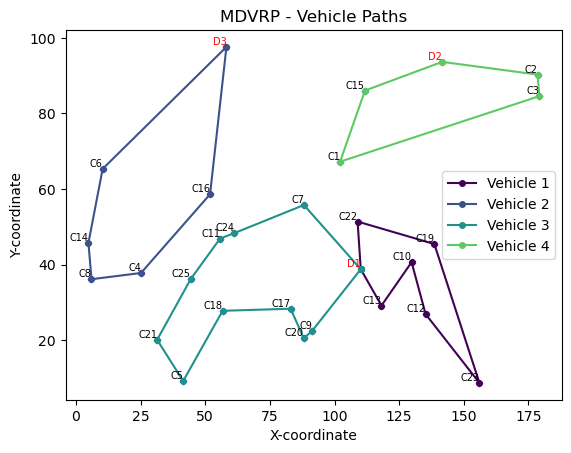

In [15]:
# plt.figure(figsize=(10, 6))

def plot_paths(paths, xc, yc, W):
    for i, path in enumerate(paths):
        color = plt.cm.viridis(i / len(paths))
        plt.plot([xc[node] for node in path], [yc[node] for node in path], marker='o', markersize=4, linestyle='-', color=color, label=f'Vehicle {i + 1}')

# Mark depots with red and customers with blue
    for i in range(len(xc)):
        label = f'D{i+1}' if i < I else f'C{i-I+1}'
        color = 'red' if i < I else 'blue'
        plt.scatter(xc[i], yc[i], marker='D', s=10, color=color)
        if i < I:
            plt.text(xc[i], yc[i], label, fontsize=7, color='red', ha='right', va='bottom')
        else:
            plt.text(xc[i], yc[i], label, fontsize=7, color='black', ha='right', va='bottom')

    plt.title('MDVRP - Vehicle Paths')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
#     plt.grid(True)
    plt.savefig(f"W_{W}.png")
    plt.show()

plot_paths(paths, xc, yc, W)

In [16]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
else:
    print("Optimization did not converge to an optimal solution.")

Optimization did not converge to an optimal solution.


In [17]:
count=0
for j in JS:
    if a[j]<=u[j].x and u[j].x<=b[j]:
        count=count+1
    print(j-2, " ", a[j], " ", b[j], " ", u[j].x)

1   4   31   13.476581812384135
2   5   21   5.0
3   3   32   5.574741893447932
4   6   18   6.0
5   5   47   17.03312163648667
6   8   26   17.950234786141664
7   2   10   2.0
8   1   15   7.921219616779126
9   8   40   23.381974605610594
10   5   10   10.0
11   9   40   9.17515505454505
12   9   51   11.476041435496882
13   5   19   5.0
14   2   16   8.889637986663729
15   5   38   15.589084685551951
16   1   26   1.0
17   6   54   22.06902738998179
18   7   44   19.436928219627617
19   8   51   18.307473680120893
20   1   23   23.0
21   8   15   15.0
22   9   33   21.336099056876222
23   2   31   14.240821358864213
24   6   19   8.59871550626125
25   4   33   10.730174383264966


In [18]:
print("No of customers whose order is not delivered within time window", J-count)

No of customers whose order is not delivered within time window 0
